# Libraries

In [2]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#from tensorflow.keras.utils.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

# Reading to dataset

In [ ]:
data = {}
for root, _, filenames in os.walk('/Users/TO5Y/Desktop/tumor/Training'):
    dirname = root.split('/')[-1]
    
    for filename in filenames:
        
        if dirname not in data.keys():
            data[dirname] = []
        
        data[dirname].append(os.path.join(root, filename))

#Drawing an pie plot for data balance
ds = pd.Series([len(data[k]) for k in data.keys()], index = data.keys())
ds.plot(title='Data', kind='pie', autopct='%1.0f%%')

NameError: name 'os' is not defined

# visualize image

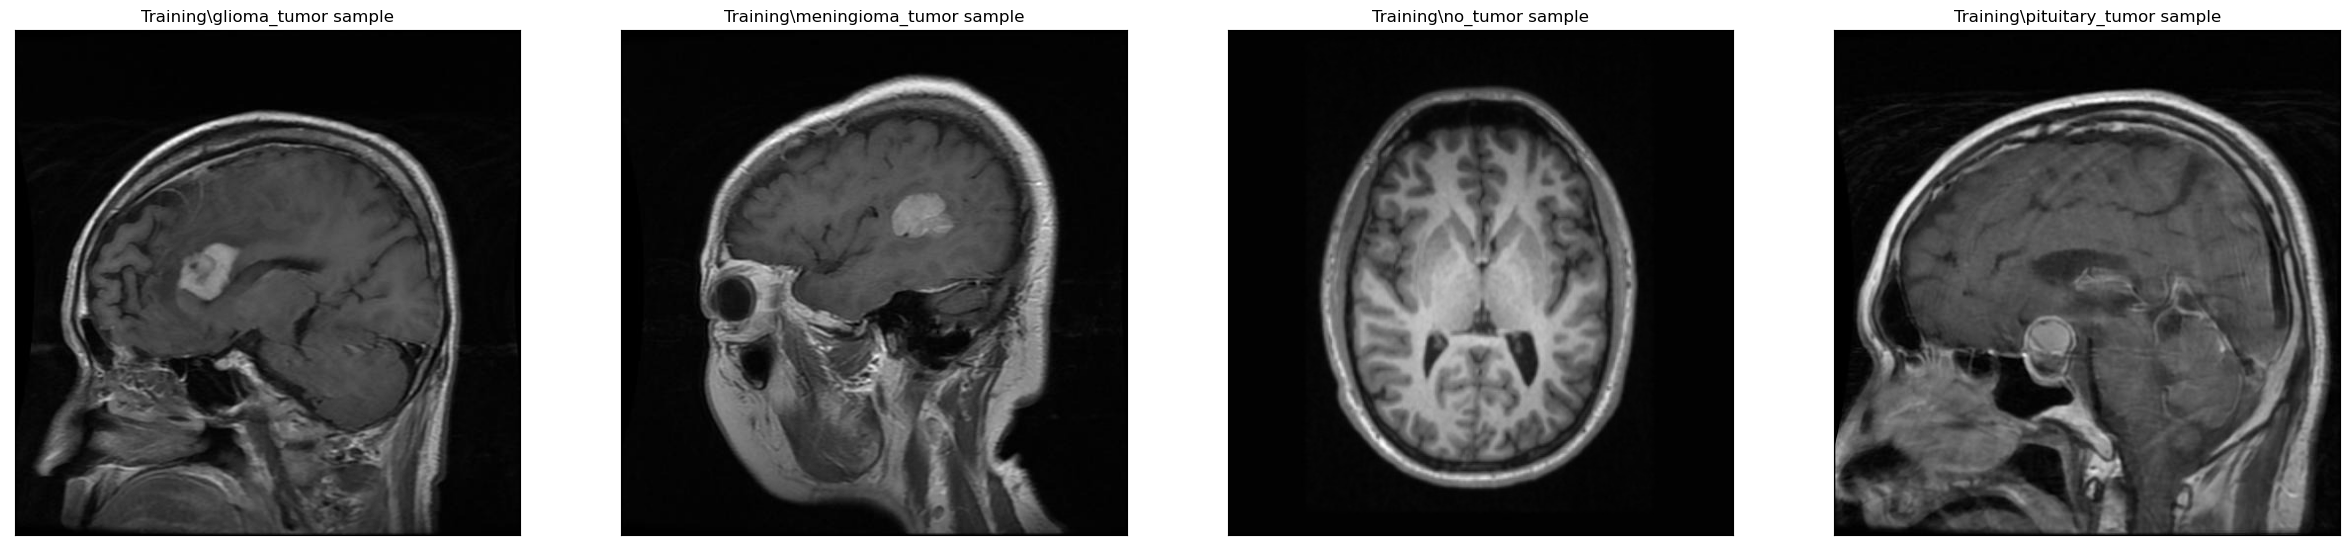

In [3]:
plt.figure(figsize=(30, 20))

samples = []
for i, k in enumerate(data.keys()):
    s = cv2.imread(random.choice(data[k]))
    s = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    samples.append(s)
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(samples[-1], cmap='gray')
    plt.title(k + ' sample')
    plt.xticks([])
    plt.yticks([])

# Applying Edge Detection:

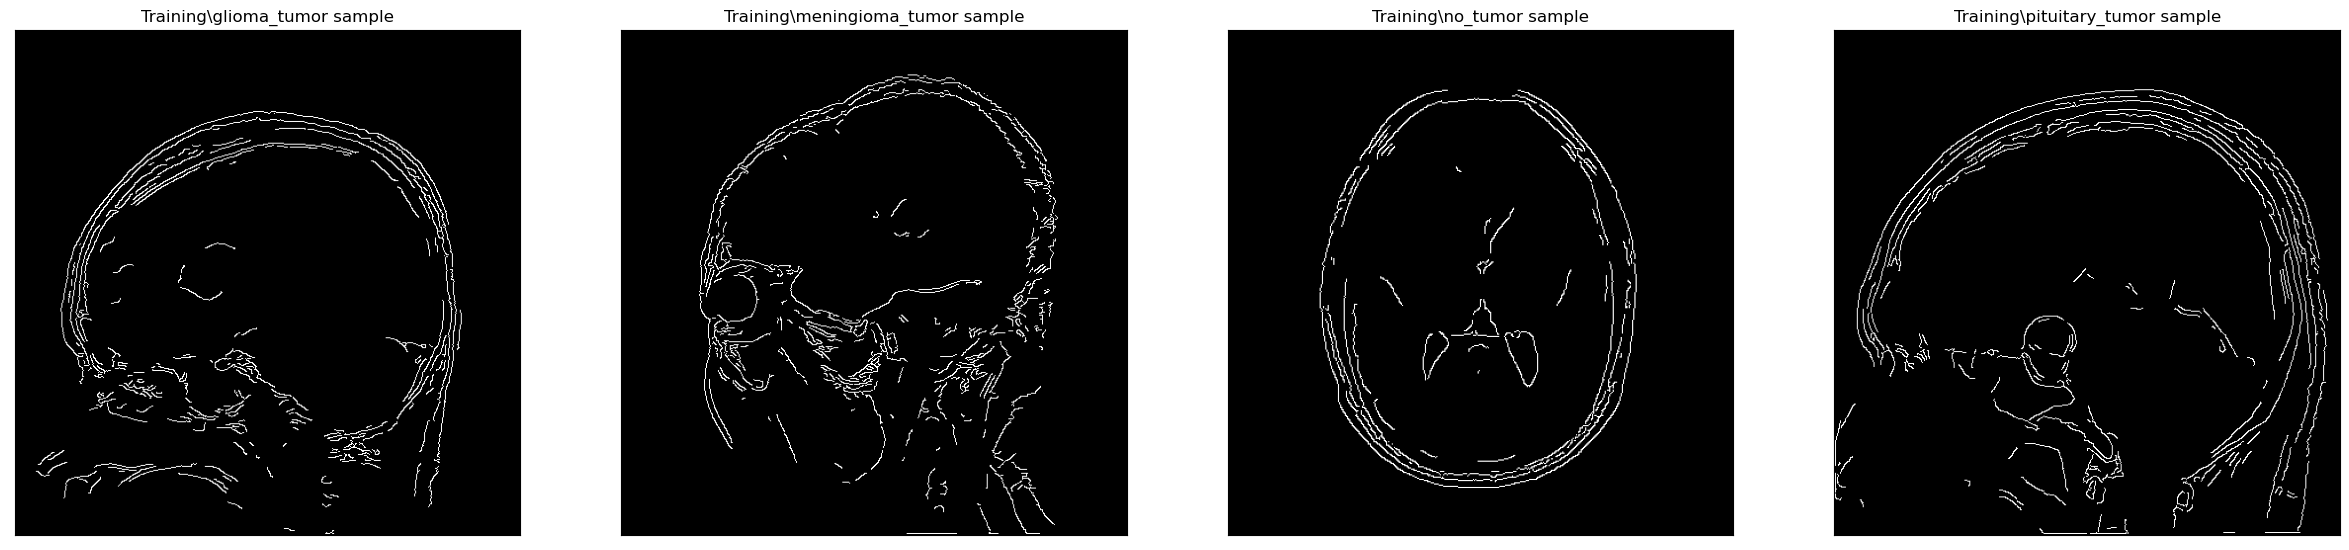

In [4]:

plt.figure(figsize=(30, 20))

for i, s in enumerate(samples):
    s = cv2.Canny(s, threshold1=140, threshold2=210)
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(s, cmap='gray')
    plt.title(list(data.keys())[i] + ' sample')
    plt.xticks([])
    plt.yticks([])

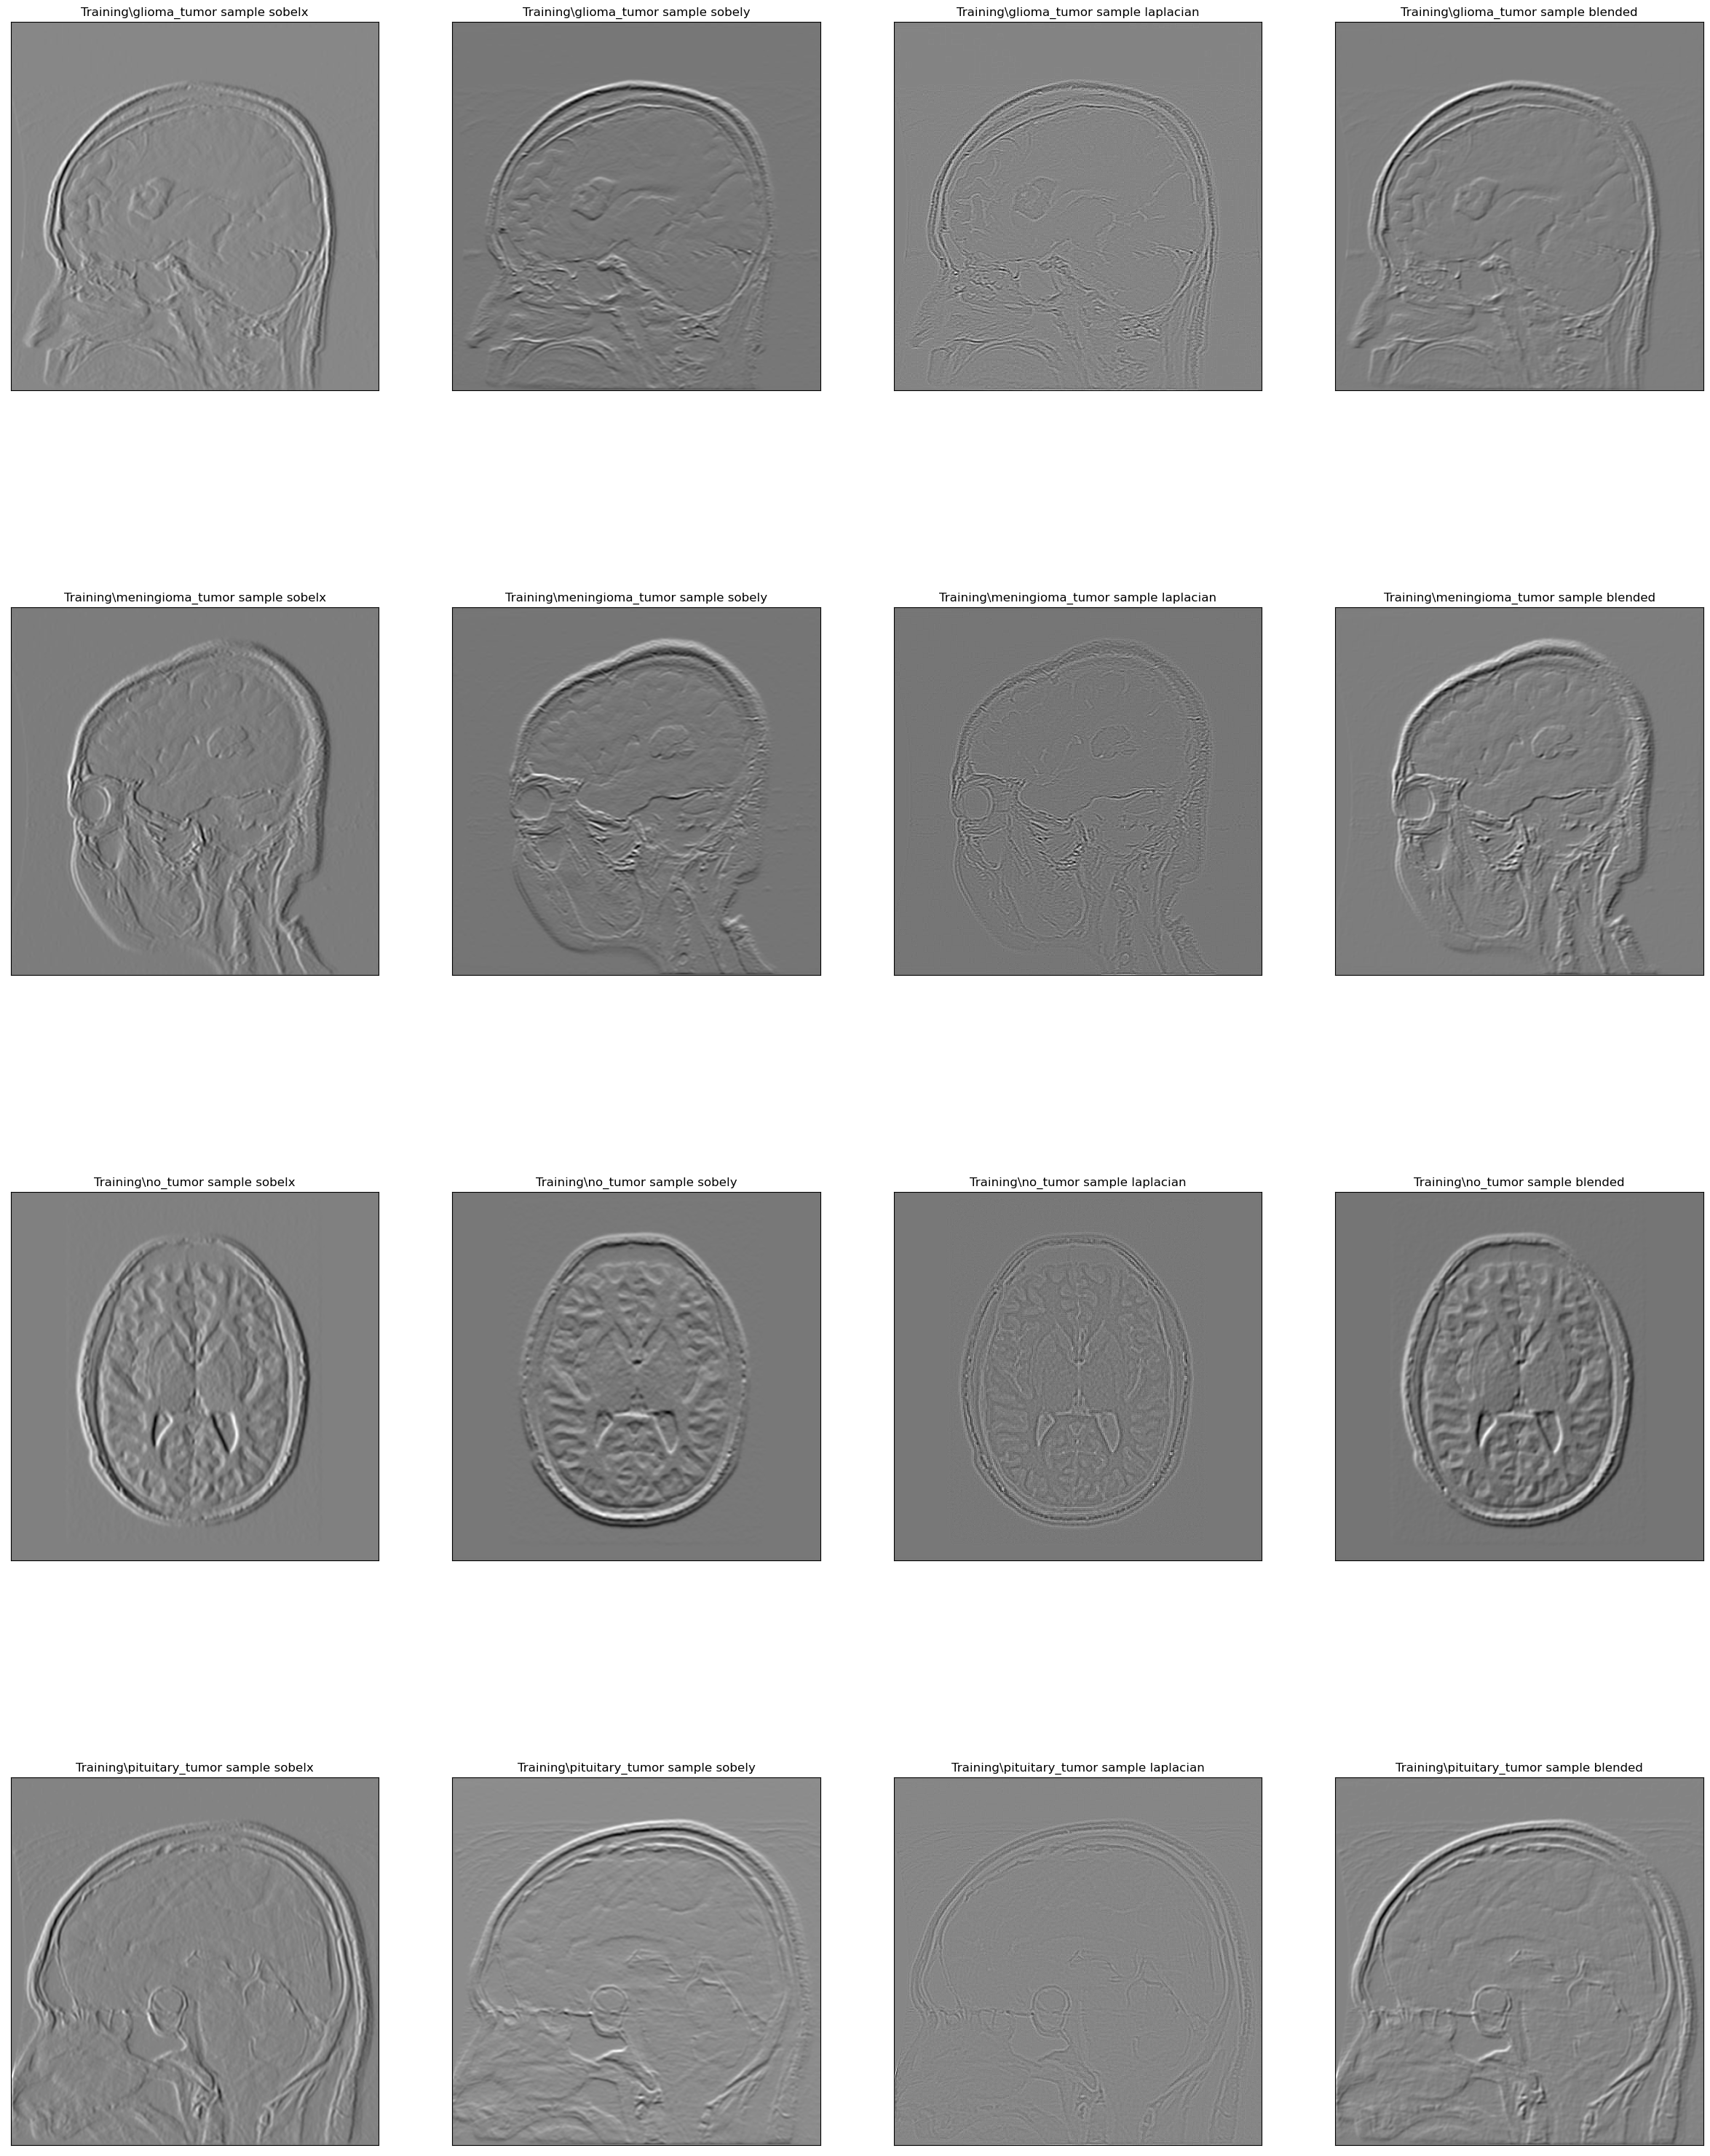

In [5]:
plt.figure(figsize=(30, 40))

j = 0
for i, s in enumerate(samples):
    sobelx = cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(s, cv2.CV_64F, 0, 1, ksize=5)
    laplacian = cv2.Laplacian(s, cv2.CV_64F)
    blended = cv2.addWeighted(src1=sobelx, alpha=0.5, src2=sobely, beta=0.5,gamma=0)
    
    plt.subplot(4, 4, i + j + 1)
    plt.imshow(sobelx, cmap='gray')
    plt.title(list(data.keys())[i] + ' sample sobelx')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4, 4, i + j + 2)
    plt.imshow(sobely, cmap='gray')
    plt.title(list(data.keys())[i] + ' sample sobely')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4, 4, i + j + 3)
    plt.imshow(laplacian, cmap='gray')
    plt.title(list(data.keys())[i] + ' sample laplacian')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4, 4, i + j + 4)
    plt.imshow(blended, cmap='gray')
    plt.title(list(data.keys())[i] + ' sample blended')
    plt.xticks([])
    plt.yticks([])
    
    j += 3


In [6]:
lrate = 1e-3
epochs = 100
batch_size = 8

train_path = "Training"
test_path = "Testing"


train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(200 , 200),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(200 ,200),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 2297 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


# ResNet50

In [7]:
# Convoluted Base MODEL
conv_base = ResNet50(weights='imagenet',
include_top=False,
input_shape=(200, 200, 3))
# MODEL
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='sigmoid'))

In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 30,010,564
Trainable params: 29,957,444
No

In [9]:
for layer in conv_base.layers[:]:
    layer.trainable = False
print('conv_base is now NOT trainable')
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

conv_base is now NOT trainable
0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2

In [10]:
model.compile(loss = 'binary_crossentropy',metrics = ['accuracy']
,optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005))
print("model compiled")
print(model.summary())


model compiled
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 30,010,564
Trainable params

In [ ]:
history = model.fit(train_generator, epochs=20)

Epoch 1/20
288/288 [==============================] - 786s 3s/step - loss: 0.6333 - accuracy: 0.3352
Epoch 2/20
288/288 [==============================] - 965s 3s/step - loss: 0.5759 - accuracy: 0.3770
Epoch 3/20
240/288 [========================>.....] - ETA: 2:23 - loss: 0.5633 - accuracy: 0.3958